In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy
from scipy.optimize import curve_fit

In [2]:
# To use LaTeX and select Helvetica as the default font, without editing matplotlibrc use:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{physics}')
plt.rc('font', family='serif')

In [3]:
# Close all open figures
plt.close("all")
plt.rcdefaults()

In [4]:
data_label = [r'${}^{6}\mathrm{Li}$: $2s\,{}^{2}{S}_{1/2},\,F=3/2 \rightarrow 3p\,{}^{2}{P}_{3/2}$',
              r'${}^{6}\mathrm{Li}$: $2s\,{}^{2}{S}_{1/2},\,F=3/2 \rightarrow 2p\,{}^{2}{P}_{3/2}$',
              r'${}^{88}\mathrm{Sr}$: $5s^{2}\,{}^{1}{S}_{0} \rightarrow 5s5p\,{}^{3}{P}_{1}$']

data = {'Wavenumber (avg)': [15462.5851, 14903.6295254, 14504.33824159], 
        'Wavenumber (std)': [0.0005, 0.0000007, 0.00000033], 
        'Deviation (avg)': [135, 131, 120], 
        'Deviation (std)': [21, 10, 10], 
        'marker' : ['s','^','o'],
        'label': data_label}

wm_linear = pd.DataFrame(data)
wm_linear['Wavelength (avg)'] = unumpy.nominal_values(10**7/unumpy.uarray(wm_linear['Wavenumber (avg)'], wm_linear['Wavenumber (std)']))
wm_linear['Wavelength (std)'] = unumpy.std_devs(10**7/unumpy.uarray(wm_linear['Wavenumber (avg)'], wm_linear['Wavenumber (std)']))

In [5]:
def lin_func(x, m, b):
    return m*x + b

def gauss_func(x, A, mu, sigma):
    # Returns unnormalized Gaussian
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [6]:
# Generate array of coefficients from linear fits

# Plot range
[x_min, x_max] = [625, 705]
[y_min, y_max] = [70, 225]

mc_loops = 50000
#mc_loops = 100

# Linear fit coefficients (m, b)
lin_fit_coeffs = np.zeros((mc_loops, 2))

np.random.seed(0)

for i in range(mc_loops):
    x_temp = np.random.normal(loc=wm_linear['Wavelength (avg)'], scale=wm_linear['Wavelength (std)'])
    y_temp = np.random.normal(loc=wm_linear['Deviation (avg)'], scale=wm_linear['Deviation (std)'])
    
    popt, pcov = curve_fit(lin_func, x_temp, y_temp)
    lin_fit_coeffs[i] = popt

print('Finished MC')

X = np.linspace(x_min, x_max, 1000)
Y = np.linspace(y_min, y_max, 1000)

# Arrays to hold centers and widths
gauss_mu = np.zeros(len(X))
gauss_sigma = np.zeros(len(X))

# For each x-coordinate, fit histogram of y-points
for i in range(len(X)):
    
    y = lin_func(X[i], lin_fit_coeffs[:,0], lin_fit_coeffs[:,1])
    y_hist, y_bin_edges = np.histogram(y, bins='auto')
    
    # Calculate histogram bin centers
    y_bin_centers = np.zeros(len(y_bin_edges)-1)
    for j in range(len(y_bin_centers)):
        y_bin_centers[j] = (y_bin_edges[j+1]+y_bin_edges[j])/2

    init_A = np.max(y_hist)
    init_mu = np.abs(np.max(y_bin_centers)-np.min(y_bin_centers))/2
    init_sigma = np.abs(init_mu/3)
    
    init_guess = [init_A, init_mu, init_sigma]
    
    popt, pcov = curve_fit(gauss_func, y_bin_centers, y_hist, p0 = init_guess, 
                           bounds = ([0, 0, 0], [mc_loops, 300, 200]))
    
    gauss_mu[i] = popt[1]
    gauss_sigma[i] = np.abs(popt[2])

print('Finished Gaussian fits')

popt, pcov = curve_fit(lin_func, wm_linear['Wavelength (avg)'], wm_linear['Deviation (avg)'], 
                                           sigma = wm_linear['Deviation (std)'])

Finished MC
Finished Gaussian fits


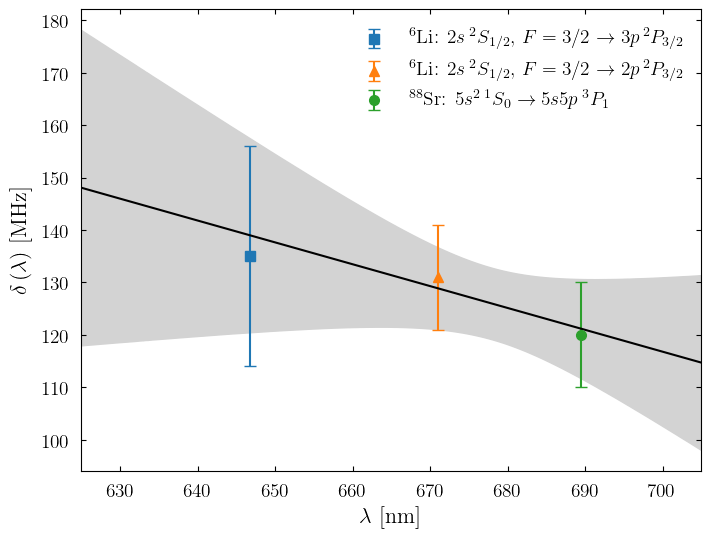

In [11]:
#rc_params = {'font.family':'arial',
#             'xtick.labelsize':14,
#             'ytick.labelsize':14, 
#             'legend.fontsize':14, 
#             'axes.labelsize':20}

rc_params = {'xtick.labelsize':14,
             'ytick.labelsize':14, 
             'legend.fontsize':14, 
             'axes.labelsize':16,
             'text.usetex':True,
             'text.latex.preamble':r'\usepackage{physics}',
             'font.family':'serif'}

with plt.rc_context(rc_params):
    plt.figure(figsize = (8,6))

    for index, row in wm_linear.iterrows():
            plt.errorbar(row['Wavelength (avg)'], row['Deviation (avg)'], yerr = row['Deviation (std)'], 
                                   fmt=row['marker'], capsize=4, label=row['label'], markersize=7)

    plt.plot(X, lin_func(X, popt[0], popt[1]), color='black')
    plt.fill_between(X, lin_func(X, popt[0], popt[1]) + gauss_sigma,
                     lin_func(X, popt[0], popt[1]) - gauss_sigma, 
                     color = 'lightgray')
    #plt.plot(X, lin_func(X, popt[0], popt[1]) + gauss_sigma)
    #plt.plot(X, lin_func(X, popt[0], popt[1]) - gauss_sigma)

    plt.xlim((x_min, x_max))
    #plt.ylim((y_min, y_max))

    plt.legend(loc='best', frameon=False)
    plt.xlabel(r'$\lambda$ [nm]', ha='center')
    plt.ylabel(r'$\delta\left(\lambda\right)$ [MHz]', labelpad=15, va='center')

    # Workaround to fix ticks chaning fonts when using latex
    # https://stackoverflow.com/questions/43248336/matplotlib-tick-labels-are-inconsist-with-font-setting-latex-text-example
    #plt.xticks(np.linspace(x_min, x_max, 8))
    #plt.yticks(np.linspace(y_min, y_max, 7))

    ax = plt.gca()
    ax.tick_params(which='both', axis='both', direction='in', pad=8)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    plt.savefig('wm_fit.svg', bbox_inches='tight')
    plt.show()